# prepare the data
# 准备数据

In [1]:
import pyqpanda as q 
import numpy as np
from pyqpanda import *
from tqdm.notebook import tqdm

<img src = 'Q_question.png' width = '1000'>

In [2]:
#define our problem
problem = {'Z0 Z4':0.73,'Z0 Z5':0.33,'Z0 Z6':0.5,'Z1 Z4':0.69,'Z1 Z5':0.36,
       'Z2 Z5':0.88,'Z2 Z6':0.58,'Z3 Z5':0.67,'Z3 Z6':0.43}

<img src = 'Qmap.png' width = '1000'>

# 定义量子线路 

In [3]:
#def q map 定义量子线路
def oneCircuit(qlist, Hamiltontian, beta, gamma): #def 一组量子BIT 一组hamilton的数据 beta and gamma
    vqc = q.VariationalQuantumCircuit()
    for i in range(len(Hamiltontian)):
        temp_vec = []  #临时数组记录当前的 表达式.
        item = Hamiltontian[i]
        dictionary_p = item[0] #一个字典 表达量子比特的索引
        for iter in dictionary_p:
            if 'Z' != dictionary_p[iter]:  #简单判断字典是否属于泡利Z门
                pass
            temp_vec.append(qlist[iter])  # 如果是,则记录该量子BIT
        coef = item[1] #记录edge 的各自权重
        
        if 2 != len(temp_vec):  #判断每个表达式使用的逻辑门的bit数是否为两个
            pass    #不是就pass掉
        
        vqc.insert(q.VariationalQuantumGate_CNOT(temp_vec[0], temp_vec[1]))  #插入gate 变量1是控制bit 变量2是受控BIT
        vqc.insert(q.VariationalQuantumGate_RZ(temp_vec[1], 2 * gamma * coef))  
        vqc.insert(q.VariationalQuantumGate_CNOT(temp_vec[0], temp_vec[1]))  #插入gate 变量1是控制bit 变量2是受控BIT
        
    for j in qlist:
        vqc.insert(q.VariationalQuantumGate_RX(j, 2.0 * beta))
                
    return vqc    

# 算法实现

In [4]:
Hp = q.PauliOperator(problem)
qubit_num = Hp.getMaxIndex()
trial_num = 100
Loss = np.zeros(trial_num)

#machine = q.init_quantum_machine(QMachineType.CPU)
machine = q.init_quantum_machine(QMachineType.CPU)
qlist = machine.qAlloc_many(qubit_num)

step = 5

beta = q.var(np.ones((step, 1), dtype = 'float64'), True)
gamma = q.var(np.ones((step, 1), dtype = 'float64'), True)

vqc = q.VariationalQuantumCircuit()

for i in qlist:
    vqc.insert(q.VariationalQuantumGate_H(i))
    
for i in range(step):
    vqc.insert(oneCircuit(qlist, Hp.toHamiltonian(1), beta[i], gamma[i]))

loss = q.qop(vqc, Hp, machine, qlist)

optimizer = q.MomentumOptimizer.minimize(loss, 0.02, 0.9)

leaves = optimizer.get_variables()

for i in tqdm(range(trial_num),"Trail time"):
    loss_value = optimizer.get_loss()
    Loss[i] = loss_value
    #print("i:",i,"loss:",loss_value)
    optimizer.run(leaves, 0)

    

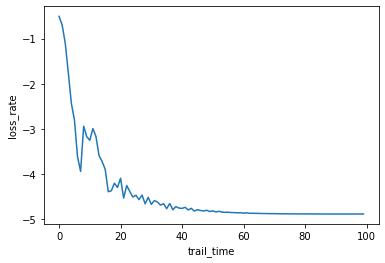

In [5]:
import matplotlib.pyplot as plt
plt.plot(Loss)
plt.ylabel('loss_rate')
plt.xlabel('trail_time')
plt.show()

# 结果验证

In [6]:
prog=q.QProg()
circuit = vqc.feed()
prog.insert(circuit)
q.directly_run(prog)

result = q.quick_measure(qlist, trial_num)

In [7]:
q_candidate = []
q_occurance = []
q_result = result.keys()
for item in q_result:
    q_candidate.append(item)
    q_occurance.append(result[item])

Text(0.5, 0, 'Occurance')

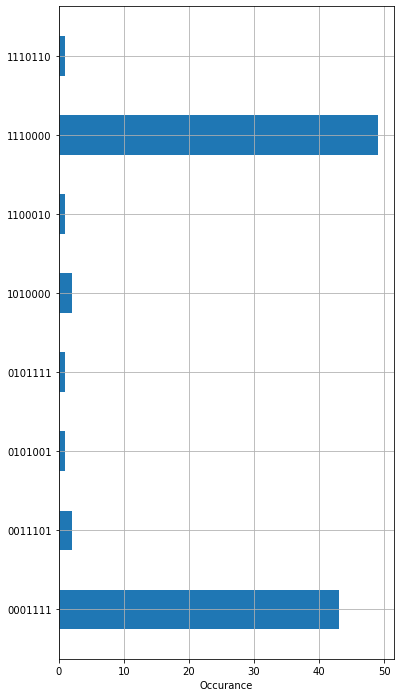

In [8]:
plt.figure(figsize = (6,12))
plt.barh(q_candidate, q_occurance, height=0.5, align='center')
plt.grid(True)
plt.xlabel('Occurance')